In [1]:
import sys
import os
import yaml
from pathlib import Path
import torch
import traceback
import igl
import numpy as np

from customconfig import Properties

current_path = os.getcwd()
base_path = os.path.dirname(current_path)

sys.path.append(base_path)
from nn.experiment import ExperimentWrappper
from pattern.wrappers import VisPattern
import nn.data as data

/home/yuki/anaconda3/envs/ntailor-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def sample_points_obj(filename, num_points):
    """Sample point cloud from .obj file"""
    # TODO Use the same function as the main code?
    verts, faces = igl.read_triangle_mesh(str(filename))

    # np.random.seed(601)
    for _ in range(3):
        barycentric_samples, face_ids = igl.random_points_on_mesh(
            num_points, verts, faces
        )

        points = np.empty(barycentric_samples.shape)
        for i in range(len(face_ids)):
            face = faces[face_ids[i]]
            barycentric_coords = barycentric_samples[i]
            face_verts = verts[face]
            points[i] = np.dot(barycentric_coords, face_verts)

    return points

def load_points(filename):
    """Load point cloud from .txt file with point coordinates"""
    with open(filename, 'r') as pc_file: 
        points = []
        for line in pc_file:
            coords = [float(x) for x in line.split()]
            coords = coords[:3]
            points.append(coords)
    points = np.array(points)
    return points

In [3]:
system_info = Properties(os.path.join(base_path, "system.json"))
shape_config_path = os.path.join(base_path, "models/att/att.yaml")
stitch_config_path = os.path.join(base_path, "models/att/stitch_model.yaml")

with open(shape_config_path, "r") as f:
    shape_config = yaml.safe_load(f)

# modify the pretrained model path
shape_config["NN"]["pre-trained"] = os.path.join(
    base_path, shape_config["NN"]["pre-trained"]
)
print(shape_config["NN"]["pre-trained"])

with open(stitch_config_path, "r") as f:
    stitch_config = yaml.safe_load(f)
stitch_config["NN"]["pre-trained"] = os.path.join(
    base_path, stitch_config["NN"]["pre-trained"]
)
print(stitch_config["NN"]["pre-trained"])

paths_list = []
target_file_path = os.path.join(
    base_path,
    "garment-data/test/jacket_hood_sleeveless_150/jacket_hood_sleeveless_0CZFN3MF45/jacket_hood_sleeveless_0CZFN3MF45_sim.obj",
)
target_file_name = os.path.splitext(os.path.basename(target_file_path))[0]
paths_list.append(Path(target_file_path))


saving_path = Path(os.path.join(base_path, system_info["output"], target_file_name))
saving_path.mkdir(parents=True, exist_ok=True)
print(saving_path)

/home/yuki/learn-computer-vision/NeuralTailor/./models/att/neural_tailor_panels.pth
/home/yuki/learn-computer-vision/NeuralTailor/./models/att/neural_tailor_stitch_model.pth
/home/yuki/learn-computer-vision/NeuralTailor/outputs/jacket_hood_sleeveless_0CZFN3MF45_sim


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
shape_experiment = ExperimentWrappper(shape_config, system_info['wandb_username'])
stitch_experiment = ExperimentWrappper(stitch_config, system_info['wandb_username'])
if not shape_experiment.is_finished():
    print('Warning::Evaluating unfinished experiment')

ExperimentWrappper::Warning::Requested status of run not connected to wandb


In [6]:
# data stats from training 
_, _, data_config = shape_experiment.data_info()  # need to get data stats

ExperimentWrappper::Warning::Skipping loading split file from cloud..
ExperimentWrappper::Warning::Skipping loading panel classes file from cloud..
ExperimentWrappper::Warning::Skipping loading parameter filter file from cloud..


In [7]:
points_list = []
for filename in paths_list:
    if '.obj' in str(filename):
        points = sample_points_obj(filename, shape_config['dataset']['mesh_samples'])
    else: 
        points = load_points(filename)

    if abs(points.shape[0] - data_config['mesh_samples']) > 10:  # some tolerance to error
        selection = np.random.permutation(points.shape[0])[:data_config['mesh_samples']]
        print('Warning::Input point cloud has {} points while {} are expected. Needed #points was sampled'.format(
            points.shape[0], data_config['mesh_samples']))
        points = points[selection]
        
    if 'standardize' in data_config:
        points = (points - data_config['standardize']['f_shift']) / data_config['standardize']['f_scale']
    points_list.append(torch.tensor(points).float())

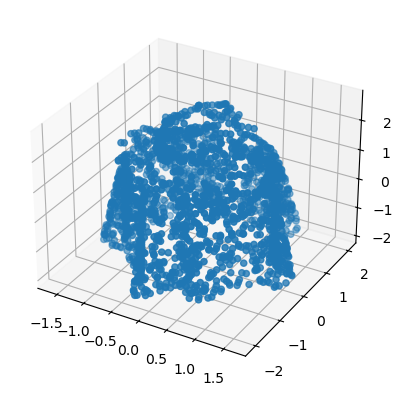

In [8]:
# show point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for points in points_list:
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])

In [9]:
%%capture
# ----- Model (Pattern Shape) architecture -----
shape_model = shape_experiment.load_model()
shape_model.eval()

In [10]:
# -------- Predict Shape ---------
with torch.no_grad():
    points_batch = torch.stack(points_list).to(device)
    predictions = shape_model(points_batch)

# ---- save shapes ----
names = [VisPattern.name_from_path(elem) for elem in paths_list]
data.save_garments_prediction(
    predictions, saving_path, data_config, names,
    stitches_from_stitch_tags='stitch' in shape_experiment.NN_config()['loss']['loss_components'])

print(f'Pattern shape saved to {saving_path}')

BasicPattern::Warning::jacket_hood_sleeveless_0CZFN3MF45_sim::Panels were updated but new stitches info was not provided. Stitches are removed.
Pattern shape saved to /home/yuki/learn-computer-vision/NeuralTailor/outputs/jacket_hood_sleeveless_0CZFN3MF45_sim


ExperimentWrappper::Warning::Skipping loading split file from cloud..
ExperimentWrappper::Warning::Skipping loading panel classes file from cloud..
ExperimentWrappper::Warning::Skipping loading parameter filter file from cloud..
ExperimentWrappper::Warning::Skipping loading split file from cloud..
ExperimentWrappper::Warning::Skipping loading panel classes file from cloud..
ExperimentWrappper::Warning::Skipping loading parameter filter file from cloud..
ExperimentWrappper::Info::Loading locally saved model
/home/yuki/learn-computer-vision/NeuralTailor/./models/att/neural_tailor_stitch_model.pth
BasicPattern::Warning::jacket_hood_sleeveless_0CZFN3MF45_sim::Panels were updated but new stitches info was not provided. Stitches are removed.
Sewing Patterns with stitches saved to /home/yuki/learn-computer-vision/NeuralTailor/outputs/jacket_hood_sleeveless_0CZFN3MF45_sim/stitched/stitched
/home/yuki/learn-computer-vision/NeuralTailor/outputs/jacket_hood_sleeveless_0CZFN3MF45_sim/stitched/stit

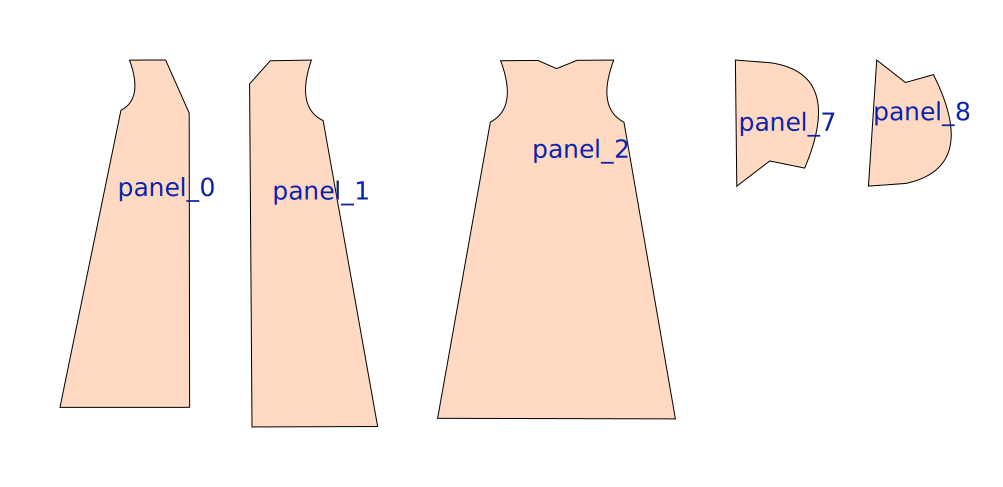

In [12]:
# ========== Stitch prediction =========
# ----- Model (Stitch Prediction) ------
_, _, stitch_data_config = stitch_experiment.data_info()  # need to get data stats
stitch_model = stitch_experiment.load_model()
stitch_model.eval()

# ----- predict & save stitches ------
saving_path = saving_path / 'stitched'
saving_path.mkdir(parents=True, exist_ok=True)

for idx, name in enumerate(names):
    # "unbatch" dictionary
    prediction = {}
    for key in predictions:
        prediction[key] = predictions[key][idx]

    if data_config is not None and 'standardize' in data_config:
        # undo standardization  (outside of generinc conversion function due to custom std structure)
        gt_shifts = data_config['standardize']['gt_shift']
        gt_scales = data_config['standardize']['gt_scale']
        for key in gt_shifts:
            if key == 'stitch_tags' and not data_config['explicit_stitch_tags']:  
                # ignore stitch tags update if explicit tags were not used
                continue
            prediction[key] = prediction[key].cpu().numpy() * gt_scales[key] + gt_shifts[key]

    pattern = data.NNSewingPattern(view_ids=False)
    pattern.name = name
    try:
        pattern.pattern_from_tensors(
            prediction['outlines'], prediction['rotations'], prediction['translations'], 
            padded=True)   
        pattern.stitches_from_pair_classifier(stitch_model, stitch_data_config['standardize'])
        pattern.serialize(saving_path, to_subfolder=True)

    except (RuntimeError, data.InvalidPatternDefError, TypeError) as e:
        print(traceback.format_exc())
        print(e)
        print('Saving predictions::Skipping pattern {}'.format(name))
        pass

print(f'Sewing Patterns with stitches saved to {saving_path}')

# show result
saving_svg_path = saving_path / name / f'{name}_pattern.svg'
print(saving_svg_path)
# show svg
from IPython.display import SVG
SVG(filename=str(saving_svg_path))